# Methods and Parameters for Feature Detection: Part 2

In this notebook, we will contninue to look in detail at tobac's feature detection and examine the remaining parameters.

We will treat:

- [Object Erosion Parameter](#Object-Erosion-Parameter-n_erosion_threshold)
- [Minimum Object Pair Distance](#Minimum-Object-Pair-Distance-min_distance)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

import seaborn as sns

sns.set_context("talk")


import warnings

warnings.filterwarnings("ignore")

In [2]:
import tobac
import tobac.testing

## Object Erosion Parameter `n_erosion_threshold`

To understand this parameter we have to look at one varibale of the feature-Datasets we did not mention so far: *num*

The value of *num* for a specific feature tells us the number of datapoints exceeding the threshold. *n_erosion_threshold* reduces this number by [eroding](https://en.wikipedia.org/wiki/Erosion_%28morphology%29) the mask of the feature on its boundary. Supose we are looking at the gaussian data again and we set a treshold of 0.5. The resulting mask of our feature will look like this:

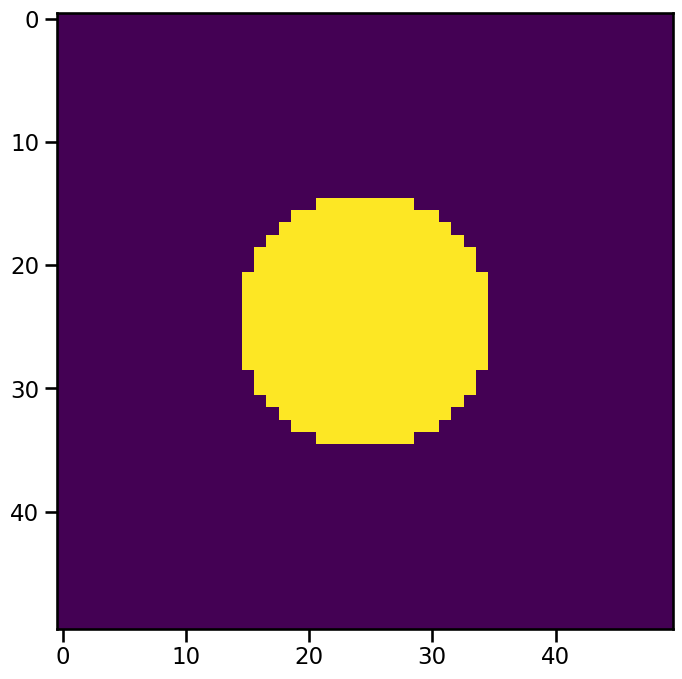

In [3]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp = np.exp(-(xx**2 + yy**2))

gaussian_data = np.expand_dims(exp, axis=0)
threshold = 0.5

mask = gaussian_data > threshold
mask = mask[0]

plt.figure(figsize=(8, 8))
plt.imshow(mask)
plt.show()

The erosion algorithm used by tobac is imported from *skimage.morphology*:

In [4]:
from skimage.morphology import binary_erosion

Applying this algorithm requires a quadratic matrix. The size of this matrix is provided by the *n_erosion_threshold* parameter. For a quick demonstration we can create the matrix by hand and apply the erosion for different values:

Text(0.5, 1.0, '$\\mathtt{n\\_erosion\\_threshold} = 10$')

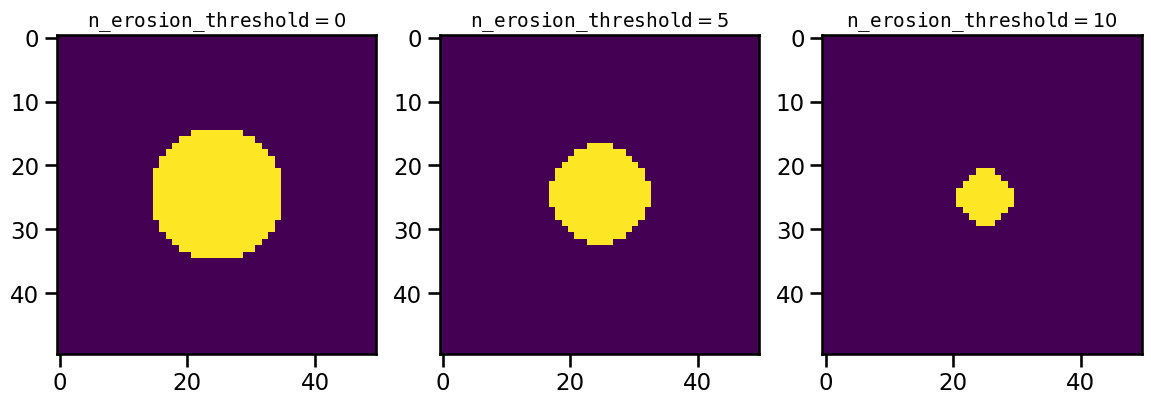

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 10))

im0 = axes[0].imshow(mask)
axes[0].set_title(r"$\mathtt{n\_erosion\_threshold} = 0$", fontsize=14)

n_erosion_threshold = 5
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er = binary_erosion(mask, selem).astype(np.int64)

im1 = axes[1].imshow(mask_er)
axes[1].set_title(r"$\mathtt{n\_erosion\_threshold} = 5$", fontsize=14)

n_erosion_threshold = 10
selem = np.ones((n_erosion_threshold, n_erosion_threshold))
mask_er_more = binary_erosion(mask, selem).astype(np.int64)

im2 = axes[2].imshow(mask_er_more)
axes[2].set_title(r"$\mathtt{n\_erosion\_threshold} = 10$", fontsize=14)

This means by using increasing values of *n_erosion_threshold* for a feature detection we will get lower values of *num*, which will match the number of **True**-values in the masks above:

In [6]:
%%capture

date = np.datetime64("2022-04-01T00:00")
input_data = xr.DataArray(
    data=gaussian_data, coords={"time": np.expand_dims(date, axis=0), "y": y, "x": x}
)
dxy = input_data["x"][1] - input_data["x"][0]

features = tobac.feature_detection_multithreshold(
    input_data, dxy, threshold, n_erosion_threshold=0
)
features_eroded = tobac.feature_detection_multithreshold(
    input_data, dxy, threshold, n_erosion_threshold=5
)
features_eroded_more = tobac.feature_detection_multithreshold(
    input_data, dxy, threshold, n_erosion_threshold=10
)

In [7]:
features["num"][0]

np.int64(332)

In [8]:
mask.sum()

np.int64(332)

In [9]:
features_eroded["num"][0]

np.int64(188)

In [10]:
mask_er.sum()

np.int64(188)

In [11]:
features_eroded_more["num"][0]

np.int64(57)

In [12]:
mask_er_more.sum()

np.int64(57)

This can be used to simplify the geometry of complex features.

## Minimum Object Size Parameter `n_min_threshold`

With *n_min_threshold* parameter we can exclude smaller features by setting a minimum of datapoints that have to exceed the threshold for one feature. If we again detect the three blobs and check their *num* value at frame 50, we can see that one of them contains fewer pixels.

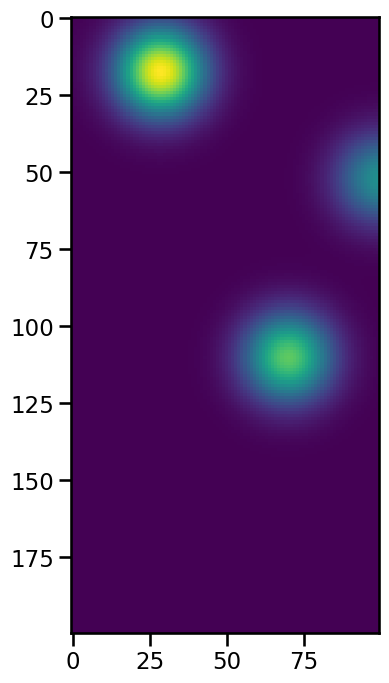

In [13]:
data = tobac.testing.make_sample_data_2D_3blobs(data_type="xarray")

plt.figure(figsize=(8, 8))
plt.imshow(data[50])
plt.show()

In [14]:
%%capture
threshold = 9
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.feature_detection_multithreshold(data, dxy, threshold)

In [15]:
features.where(features["frame"] == 50)["num"].dropna()

60    501.0
61     30.0
62    325.0
Name: num, dtype: float64

Obviously, the feature with only 30 datapoints is the rightmost feature that has almost left the imaging area. If we now use an *n_min-threshold* above or equal to 30, we will not detect this small feature:

In [16]:
%%capture
features = tobac.feature_detection_multithreshold(
    data, dxy, threshold, n_min_threshold=30
)

In [17]:
features.where(features["frame"] == 50)["num"].dropna()

60    501.0
61    325.0
Name: num, dtype: float64

Noisy data can be cleaned using this method by ignoring smaller features of no significance or, as here, features that leave the detection range.

## Minimum Object Pair Distance `min_distance`

Another way of getting rid of this specific feature is the *min_distance* parameter. It sets a minimal distance of our features. Lets detect the features as before:

In [18]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs(data_type="xarray")

threshold = 9
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.feature_detection_multithreshold(data, dxy, threshold)

A quick look at frame 50 tells us the found features and their indices:

In [19]:
n = 50
mask = features["frame"] == n
features_frame = features.where(mask).dropna()
features_frame.index.values

array([60, 61, 62])

Notice that *to_dataframe()* was used to convert the Dataset to a pandas dataframe, which is required to use the *calculate_distance* function of the analysis module. The distances bewteen our features are:

In [20]:
tobac.analysis.calculate_distance(
    features_frame.loc[60], features_frame.loc[61], method_distance="xy"
)

np.float64(77307.67873610597)

In [21]:
tobac.analysis.calculate_distance(
    features_frame.loc[62], features_frame.loc[61], method_distance="xy"
)

np.float64(64289.48419281164)

In [22]:
tobac.analysis.calculate_distance(
    features_frame.loc[62], features_frame.loc[60], method_distance="xy"
)

np.float64(101607.57596570993)

With this knowledge we can set reasonable values for *min_distance* to exclude the small feature:

In [23]:
min_distance = 70000

and perform the feature detection as usual:

In [24]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs(data_type="xarray")

thresholds = [10]
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.feature_detection_multithreshold(
    data, dxy, thresholds, min_distance=min_distance
)

n = 50
mask = features["frame"] == n

Plotting the result shows us that we now exclude the expected feature.

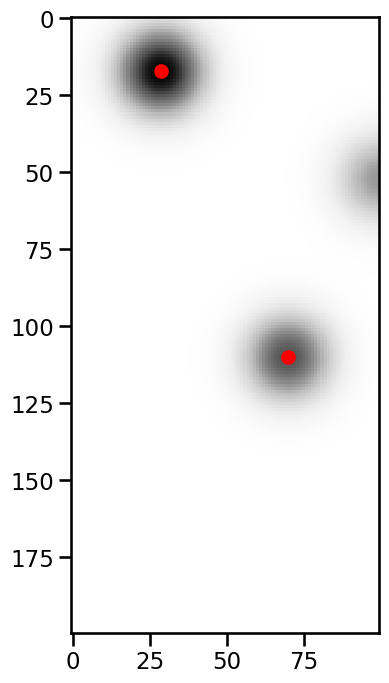

In [25]:
fig, ax1 = plt.subplots(ncols=1, figsize=(8, 8))
ax1.imshow(data.data[50], cmap="Greys")

im1 = ax1.scatter(
    features.where(mask)["hdim_2"], features.where(mask)["hdim_1"], color="red"
)

If the features have the same threshold, tobac keeps the feature with the larger area. Otherwise the feature with the higher treshold is kept.